In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix



In [2]:
mnist_train = pd.read_csv('./fashion-mnist_train.csv')
mnist_test = pd.read_csv('./fashion-mnist_test.csv')


In [3]:
mnist_train['label'].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

In [4]:
X_train, y_train, X_test, y_test = mnist_train.iloc[:,1:], mnist_train['label'], mnist_test.iloc[:,1:], mnist_test['label']
X_train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,5,0,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,1,2,0,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_train.shape

(60000, 784)

In [6]:
y_train.shape

(60000,)

In [7]:
def plot_samples(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")


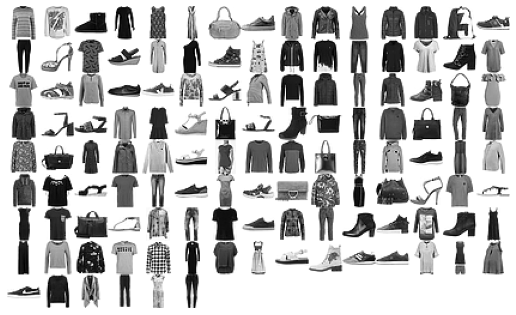

In [8]:
plt.figure(figsize=(9,9))
example_images = X_train[14:140]
plot_samples(example_images.values, images_per_row=15)
plt.show()

In [9]:
x_train_data, x_test_data, y_train_data, y_test_data = train_test_split( X_train, y_train, test_size=0.1, random_state=21)

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
print(x_train_data.shape)

print(y_train_data.shape)

(54000, 784)
(54000,)


In [12]:

pca = PCA(n_components=0.9, random_state=0,svd_solver='full')

x_train_data_pca = pca.fit_transform(x_train_data)
x_test_data_pca = pca.transform(x_test_data)
original_X_test_pca = pca.transform(X_test)


pca.n_components_


84

## pre processing

In [13]:

scaling_pipeline = Pipeline(
    [
        ('std_scaler', StandardScaler()),
        ('pca',PCA(n_components=0.90, random_state=0,svd_solver='full')),       
    ]
)

x_train_scaled = scaling_pipeline.fit_transform(x_train_data)
x_test_scaled = scaling_pipeline.transform(x_test_data)
original_X_test_scaled = scaling_pipeline.transform(X_test)


## KNN

In [14]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train_scaled,y_train_data)
knn_clf.score(x_test_scaled,y_test_data)


0.8651666666666666

### Tunning KNN

## Random Forest 

In [15]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=0,n_estimators=200, n_jobs=-1)


forest_clf.fit(x_train_scaled,y_train_data)
forest_clf.score(x_test_scaled,y_test_data)


0.8676666666666667

In [16]:
forest_params = {
     'n_estimators': [100,200,400],
     'max_depth':[None,30,100],
     'max_features': ['auto','sqrt','log2'],
     'random_state':[0]
}

In [17]:
forest_grid_search = GridSearchCV(
    RandomForestClassifier(n_jobs=-1),
    forest_params,
    cv=3,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1,
)

forest_grid_search.fit(x_train_scaled,y_train_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [None, 30, 100],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 400], 'random_state': [0]},
             return_train_score=True, scoring='accuracy')

In [18]:
forest_grid_search.best_estimator_

RandomForestClassifier(max_depth=30, n_estimators=400, n_jobs=-1,
                       random_state=0)

In [19]:
forest_grid_search.best_score_

0.8672777777777778

In [20]:
best_forest = forest_grid_search.best_estimator_

### Tunning randomForest

## XGBoost

In [21]:
import xgboost as xgb
from xgboost import XGBClassifier

In [22]:
xgb_clf = XGBClassifier(n_jobs=-1, max_depth=5,min_child_weight = 1,gamma = 0,colsample_bytree = 0.8)

xgb_clf.fit(x_train_scaled,y_train_data)
xgb_clf.score(x_test_scaled,y_test_data)

0.8785

### Tunning XGBoost

In [23]:
xgb_params = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
xgb_clf = XGBClassifier(
    objective='multi:softmax',
    n_jobs=-1,
    gamma = 0,
    colsample_bytree = 0.8)

XGBGridsearch = GridSearchCV(estimator=xgb_clf,param_grid = xgb_params,scoring='accuracy',n_jobs=-1,cv=3)
XGBGridsearch.fit(x_train_scaled,y_train_data)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None,
                                     objective='multi:softmax',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
            

In [24]:
XGBGridsearch.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=9,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
XGBGridsearch.best_score_

0.8802037037037037

In [26]:
best_xgb = XGBGridsearch.best_estimator_
best_xgb.score(original_X_test_scaled,y_test)

print(classification_report(best_xgb.predict(original_X_test_scaled),y_test))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1043
           1       0.97      0.99      0.98       982
           2       0.79      0.82      0.81       968
           3       0.92      0.89      0.90      1030
           4       0.86      0.81      0.83      1059
           5       0.93      0.96      0.94       967
           6       0.65      0.73      0.69       898
           7       0.93      0.92      0.93      1009
           8       0.98      0.96      0.97      1019
           9       0.95      0.93      0.94      1025

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



## Stacking

In [27]:
from sklearn.ensemble import StackingClassifier

In [28]:
stacking_clf = StackingClassifier(estimators=[
    ('knn', KNeighborsClassifier()),
    ('rf', best_forest),
    ('adab', XGBClassifier())]
    , final_estimator=best_xgb)

stacking_clf.fit(x_train_scaled,y_train_data)

StackingClassifier(estimators=[('knn', KNeighborsClassifier()),
                               ('rf',
                                RandomForestClassifier(max_depth=30,
                                                       n_estimators=400,
                                                       n_jobs=-1,
                                                       random_state=0)),
                               ('adab',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None, gamma=None,
                                              gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learning_...
                

In [29]:
stacking_clf.score(original_X_test_scaled,y_test)

0.8861

In [30]:
print(classification_report(stacking_clf.predict(original_X_test_scaled),y_test))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1032
           1       0.98      0.98      0.98       996
           2       0.81      0.83      0.82       982
           3       0.91      0.90      0.90      1010
           4       0.84      0.82      0.83      1028
           5       0.94      0.96      0.95       983
           6       0.68      0.72      0.70       949
           7       0.94      0.92      0.93      1018
           8       0.97      0.97      0.97      1001
           9       0.95      0.95      0.95      1001

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

